In [1]:
using SpecialFunctions  # Importing the required module for arccos function
using DifferentialEquations
using LinearAlgebra
using Combinatorics
using SymEngine
using Polynomials
using NLsolve
using Plots
using PlotlyJS
using LaTeXStrings
using TensorOperations
using Random

# using DynamicalSystems

In [2]:
import Statistics

In [3]:
function levi_cevita_tensor(dim)
    arr = zeros(Int, tuple(fill(dim, dim)...))
    for x in permutations(1:dim)
        mat = zeros(Int, (dim, dim))
        for (i, j) in enumerate(x)
            mat[i, j] = 1
        end
        arr[x...] = det(mat)
    end
    return arr
end

levi_cevita_tensor (generic function with 1 method)

In [4]:
function get_norm(T, g)
    """
    T should have configuration either 'u' or 'uu'
    """
    if ndims(T) == 2
        @tensor begin
            D[] := g[u,a]*T[v,b]*T[a,b]
        end
        # return ein"(ua,vb,ab),uv->"(g,T,T)
        return D
    else
        @tensor begin
            D[] := g[a,b]*T[b]*T[a]
        end
        # return ein"(ab,b),a->"(g,T,T)
        return D
    end
end

get_norm (generic function with 1 method)

In [123]:
function metric_tensor(r, theta, a, M=1)
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta/pi.
        Configuration: ll
    """
    g = [
        [
            (-(a^2) + 2 * M * r - r^2 + a^2 * sinpi(theta / pi)^2) / (r^2 + a^2 * cospi(theta / pi)^2),
            0,
            0,
            -((2 * a * M * r * sinpi(theta / pi)^2) / (r^2 + a^2 * cospi(theta / pi)^2)),
        ],
        [
            0,
            (r^2 + a^2 * cospi(theta / pi)^2) / (a^2 - 2 * M * r + r^2),
            0,
            0,
        ],
        [0, 0, r^2 + a^2 * cospi(theta / pi)^2, 0],
        [
            -((2 * a * M * r * sinpi(theta / pi)^2) / (r^2 + a^2 * cospi(theta / pi)^2)),
            0,
            0,
            (
                sinpi(theta / pi)^2 * ((a^2 + r^2)^2 - a^2 * (a^2 - 2 * M * r + r^2) * sinpi(theta / pi)^2)
            ) / (r^2 + a^2 * cospi(theta / pi)^2),
        ],
    ]

    return stack(g)
end


metric_tensor (generic function with 3 methods)

In [128]:
metric_tensor(1.,pi/2,0.8,1,true)

MethodError: MethodError: no method matching ComplexF64(::Vector{Float64})

Closest candidates are:
  (::Type{Complex{T}} where T<:Real)(::Any, !Matched::Any)
   @ Base complex.jl:14
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number}
   @ Base char.jl:50
  (::Type{T})(!Matched::Base.TwicePrecision) where T<:Number
   @ Base twiceprecision.jl:266
  ...


In [6]:
function antisymmetrize(arr)
    #* Function to antisymmetrize matrix
    arr = permutedims(arr, (1, 2,4,3))
    anti_arr = arr - permutedims(arr, (1,2, 4,3))
    anti_tensor = permutedims(anti_arr, (1,2, 4,3))
    return anti_tensor
end


antisymmetrize (generic function with 1 method)

In [7]:
function symmetrize(arr)
    """
    Symmetrizes a 4-dimensional Julia array along last two axes.

    Args:
        arr (Array): The input array.

    Returns:
        Array: The symmetrized array.

    Example:

        arr = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

        result = symmetrize(arr)
        display(result)
    """

    toput = permutedims(stack([arr[:, i, i] for i in range(1, 4)]),(2,1))
    de_ = zeros(Float64, 4, 4, 4)

    [de_[:, i, i] .= toput[i, :] for i in range(1, 4)]

    return arr + permutedims(arr, (1, 3, 2)) - de_
end


symmetrize (generic function with 1 method)

In [8]:
function kerr_christoffel(r, theta, a, M=1)
    """
    Function to give the Christoffel symbols for the Kerr metric.
    The Christoffel symbols are given as Gamma ^i _{jk}

    From Reference Paper, Appendix
    Config: ull
    """

    cs = zeros(4, 4, 4)

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sinpi(theta / pi)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cospi(theta / pi)^2

    cs[4, 1, 2] = M * (2 * r^2 - Sigma) / (Delta * Sigma^2) * a
    cs[1, 1, 2] = cs[4, 1, 2] * (r^2 + a^2) / a

    cs[4, 1, 3] = -2 * M * a * r / ((sinpi(theta / pi) / cospi(theta / pi)) * Sigma^2)
    cs[1, 1, 3] = a * sinpi(theta / pi)^2 * cs[4, 1, 3]

    cs[1, 2, 4] = (
        -M
        * a
        * (2 * r^2 * (r^2 + a^2) + Sigma * (r^2 - a^2))
        * sinpi(theta / pi)^2
        /
        (Delta * Sigma^2)
    )

    cs[4, 2, 4] = (
        r * Sigma * (Sigma - 2 * M * r)
        -
        M * a^2 * (2 * r^2 - Sigma) * sinpi(theta / pi)^2
    ) / (Delta * Sigma^2)

    cs[1, 3, 4] = M * a^3 * r * sinpi(theta / pi)^2 * sinpi(2 * theta / pi) / Sigma^2

    cs[4, 3, 4] = (scA - Sigma * a^2 * sinpi(theta / pi)^2) / ((sinpi(theta / pi) / cospi(theta / pi)) * Sigma^2)

    cs[2, 1, 1] = M * Delta * (2 * r^2 - Sigma) / Sigma^3

    cs[2, 1, 4] = -cs[2, 1, 1] * a * sinpi(theta / pi)^2

    cs[3, 1, 1] = -M * a * r * sinpi(2 * theta / pi) / Sigma^3 * a
    cs[3, 1, 4] = -cs[3, 1, 1] * (r^2 + a^2) / a

    cs[2, 2, 2] = r / Sigma + (M - r) / Delta

    cs[2, 3, 3] = -r * Delta / Sigma
    cs[3, 2, 3] = -cs[2, 3, 3] / Delta

    cs[2, 2, 3] = cs[3, 3, 3] = -(a^2) * sinpi(2 * theta / pi) / (2 * Sigma)
    cs[3, 2, 2] = -cs[2, 2, 3] / Delta

    cs[2, 4, 4] = (
        -Delta
        * (r * Sigma^2 - M * a^2 * (2 * r^2 - Sigma) * sinpi(theta / pi)^2)
        * sinpi(theta / pi)^2
        /
        Sigma^3
    )

    cs[3, 4, 4] = (
        -(Delta * Sigma^2 + 2 * M * r * (r^2 + a^2)^2)
        *
        sinpi(2 * theta / pi)
        /
        (2 * Sigma^3)
    )

    return symmetrize(cs)
end


kerr_christoffel (generic function with 2 methods)

In [9]:
function kerr_riemann_tensor(r, theta, a, M=1, config="ulll")
    # Define variables
    rijkl = zeros(4, 4, 4, 4)
    # Q = zeros(4,4,4,4)

    X = r^2 - 3 * a^2 * cospi(theta / pi)^2
    Y = 3 * r^2 - a^2 * cospi(theta / pi)^2

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sinpi(theta / pi)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cospi(theta / pi)^2

    rijkl[1, 1, 1, 4] = 2 * M^2 * a * r^2 * X * sinpi(theta / pi)^2 / Sigma^4
    rijkl[4, 4, 1, 4] = -rijkl[1, 1, 1, 4]
    rijkl[1, 4, 1, 4] = -rijkl[1, 1, 1, 4] / omega_k
    rijkl[4, 1, 1, 4] = -rijkl[1, 1, 1, 4] / (2 * M * a * r / (Delta - a^2 * sinpi(theta / pi)^2))

    rijkl[1, 1, 2, 3] = -(
        M^2 * a^2 * r * Y * sinpi(2 * theta / pi) / (Delta * Sigma^3)
    )
    rijkl[4, 4, 2, 3] = -rijkl[1, 1, 2, 3]
    rijkl[1, 4, 2, 3] = -rijkl[1, 1, 2, 3] / omega_k
    rijkl[4, 1, 2, 3] = -rijkl[1, 1, 2, 3] / (2 * M * a * r / (Delta - a^2 * sinpi(theta / pi)^2))

    rijkl[4, 3, 3, 4] = -(
        M * r * X * (2 * (r^2 + a^2) + a^2 * sinpi(theta / pi)^2) / Sigma^3
    )

    rijkl[1, 2, 1, 2] = -rijkl[4, 3, 3, 4] / Delta

    rijkl[1, 3, 1, 3] = -(
        M * r * X * ((r^2 + a^2) + 2 * a^2 * sinpi(theta / pi)^2) / Sigma^3
    )

    rijkl[4, 2, 2, 4] = -rijkl[1, 3, 1, 3] / Delta

    rijkl[1, 2, 1, 3] = rijkl[4, 3, 2, 4] = (
        -M
        *
        a^2
        /
        (Delta * Sigma^3)
        * Y
        * (3 * (r^2 + a^2) - 2 * M * r)
        * sinpi(theta / pi)
        * cospi(theta / pi)
    )

    rijkl[1, 3, 1, 2] = rijkl[4, 3, 2, 4] = (
        -M
        *
        a^2
        /
        (Delta * Sigma^3)
        * Y
        * (3 * (r^2 + a^2) - 4 * M * r)
        * sinpi(theta / pi)
        * cospi(theta / pi)
    )

    rijkl[4, 3, 1, 3] = -3 * M * a * r * X / Sigma^3
    rijkl[4, 2, 1, 2] = -rijkl[4, 3, 1, 3] / Delta

    rijkl[1, 3, 3, 4] = rijkl[4, 3, 1, 3] * sinpi(theta / pi)^2 * (r^2 + a^2)
    rijkl[1, 2, 2, 4] = -rijkl[1, 3, 3, 4] / Delta

    rijkl[2, 1, 1, 3] = (
        -3 * M * a^2 * Delta / Sigma^4 * Y * sinpi(theta / pi) * cospi(theta / pi)
    )
    rijkl[3, 1, 1, 2] = rijkl[2, 1, 1, 3] / Delta

    rijkl[2, 1, 2, 4] = (
        M
        * a
        * r
        /
        Sigma^4
        * X
        * sinpi(theta / pi)^2
        * (3 * (r^2 + a^2) - 4 * M * r)
    )
    rijkl[2, 4, 1, 2] = -rijkl[2, 1, 2, 4]

    rijkl[3, 1, 3, 4] = -(
        M
        * a
        * r
        /
        Sigma^4
        * X
        * sinpi(theta / pi)^2
        * (3 * (r^2 + a^2) - 2 * M * r)
    )

    rijkl[3, 4, 1, 3] = -rijkl[3, 1, 3, 4]

    rijkl[2, 1, 3, 4] = (
        -M
        * a
        * Delta
        /
        Sigma^4
        * Y
        * sinpi(theta / pi)
        * cospi(theta / pi)
        * (2 * (r^2 + a^2) + a^2 * sinpi(theta / pi)^2)
    )
    rijkl[3, 4, 1, 2] = -rijkl[2, 1, 3, 4] / Delta

    rijkl[2, 4, 1, 3] = (
        M
        * a
        * Delta
        /
        Sigma^4
        * Y
        * sinpi(theta / pi)
        * cospi(theta / pi)
        * ((r^2 + a^2) + 2 * a^2 * sinpi(theta / pi)^2)
    )

    rijkl[3, 1, 2, 4] = -rijkl[2, 4, 1, 3] / Delta

    rijkl[2, 3, 1, 4] = Delta^2 * rijkl[1, 1, 2, 3] / (2 * M * a * r)
    rijkl[3, 2, 1, 4] = -rijkl[2, 3, 1, 4] / Delta

    rijkl[2, 4, 3, 4] = -(r^2 + a^2) * sinpi(theta / pi)^2 * rijkl[2, 1, 1, 3]
    rijkl[3, 4, 2, 4] = rijkl[2, 4, 3, 4] / Delta

    rijkl[2, 3, 2, 3] = -M * r * X / Sigma^2
    rijkl[3, 2, 2, 3] = -rijkl[2, 3, 2, 3] / Delta

    rijkl[1, 2, 3, 4] = (
        -M
        * a
        * Y
        * (2 * (r^2 + a^2)^2 + Delta * a^2 * sinpi(theta / pi)^2)
        * sinpi(theta / pi)
        * cospi(theta / pi)
        /
        (Delta * Sigma^3)
    )
    rijkl[1, 3, 2, 4] = (
        -M
        * a
        * Y
        * ((r^2 + a^2)^2 + 2 * Delta * a^2 * sinpi(theta / pi)^2)
        * sinpi(theta / pi)
        * cospi(theta / pi)
        /
        (Delta * Sigma^3)
    )

    rijkl[4, 2, 1, 3] = (
        -M
        * a
        * Y
        * (Delta + 2 * a^2 * sinpi(theta / pi)^2)
        /
        ((sinpi(theta / pi) / cospi(theta / pi)) * Delta * Sigma^3)
    )
    rijkl[4, 3, 1, 2] = (
        -M
        * a
        * Y
        * (2 * Delta + a^2 * sinpi(theta / pi)^2)
        /
        ((sinpi(theta / pi) / cospi(theta / pi)) * Delta * Sigma^3)
    )

    rijkl[2, 1, 1, 2] = (
        M * r * X * (2 * Delta + a^2 * sinpi(theta / pi)^2) / Sigma^4
    )

    rijkl[3, 1, 1, 3] = -(
        M * r * X * (Delta + 2 * a^2 * sinpi(theta / pi)^2) / Sigma^4
    )

    rijkl[2, 4, 2, 4] = (
        -M * r * X * ((r^2 + a^2)^2 + 2 * Delta * a^2 * sinpi(theta / pi)^2) * sinpi(theta / pi)^2 / Sigma^4
    )
    rijkl[3, 4, 3, 4] = (
        M * r * X * (2 * (r^2 + a^2)^2 + Delta * a^2 * sinpi(theta / pi)^2) * sinpi(theta / pi)^2 / Sigma^4
    )

    gk = metric_tensor(r, theta, a, M)
    arijkl = antisymmetrize(rijkl)

    if config == "ulll"
        return arijkl
    elseif config == "llll"
        rulll = arijkl
        # return ein"ij,jklm->iklm"(gk, rulll)
        @tensor begin
            G[i, k, l, m] := gk[i, j] * rulll[j, k, l, m]
        end
        return G
    else
        # Config: lluu
        gkinv = inv(gk)
        # rllll = antisymmetrize(
        #     ein"ij,jklm->iklm"(gk, rijkl)
        # )
        @tensor begin
            rllll[i, k, l, m] := gk[i, j] * arijkl[j, k, l, m]
        end
        # rllll=E
        # return ein"kjlm,al,bm->kjab"(rllll, gkinv, gkinv)

        @tensor begin
            F[k, j, a, b] := rllll[k, j, l, m] * gkinv[a, l] * gkinv[b, m]
        end
        return F
    end
end


kerr_riemann_tensor (generic function with 3 methods)

In [10]:

function spin_matrix(sa, pb, gk, epsilon)
    # Resultant Config: aa
    # Input Config: u,u,uu,llll
    # In Tetrad Basis or Coordinate basis
    gkinv = inv(gk)
    # return ein"(ab,cd,bdkl,l),k -> ac"(gkinv, gkinv, epsilon, sa, pb)
    @tensor begin
        E[a,c] := gkinv[a,b]*gkinv[c,d]*epsilon[b,d,k,l]*sa[l]*pb[k]
    end
    return E
end


spin_matrix (generic function with 1 method)

In [11]:
function get_dual(r, theta, a, epsilon, config="lluu", M=1,cpx=0)
    # Eq 5.28 Format
    # Q=zeros(4,4,4,4)
    rijkl = kerr_riemann_tensor(r, theta, a, M, config,cpx)
    # return ein"ijkl,klmn->ijmn"( rijkl, epsilon )* 0.5
    @tensor begin
        E[i,j,m,n]:=rijkl[i,j,k,l]*epsilon[k,l,m,n]
    end
    return E.*0.5
end


get_dual (generic function with 4 methods)

In [12]:
function get_dual_dual(r, theta, a, gk, epsilon, M=1,cpx=0)
    # Eq 5.31 Format
    gkinv = inv(gk)
    # Q=zeros(4,4,4,4)
    drijkl = get_dual(r, theta, a, epsilon,"lluu", M,cpx)
    # Config: llll
    # sdrijkl = ein"ij,kl,jlps->ikps"(gkinv, gkinv, drijkl)  # Config: uull
    @tensor begin
        sdrijkl[i,k,p,s]:=gkinv[i,j]*gkinv[k,l]*drijkl[j,l,p,s]
    end
    # return ein"uvab,abps->uvps"(epsilon,sdrijkl)* 0.5
    @tensor begin
        E[u,v,p,s]:=epsilon[u,v,a,b]*sdrijkl[a,b,p,s]
    end
    return E*0.5
end

get_dual_dual (generic function with 3 methods)

In [13]:
function to_cartesian(rsol)
    r, t, p = rsol[2], rsol[3], rsol[4]
    vr,vt,vp= rsol[5],rsol[6],rsol[7]

    x = r .* sin(t) .* cos(p)
    y = r .* sin(t) .* sin(p)
    z = r .* cos(t)

    vx = vr .* sin(vt) .* cos(vp)
    vy = vr .* sin(vt) .* sin(vp)
    vz=vr.*cos(vt)

    return hcat(x, y, z),hcat(vx,vy,vz)
end


to_cartesian (generic function with 1 method)

In [14]:
function rhs23(y, vmu, sp, ps, gk, epsilon, a, M=1.0,cpx=0)
    _, r, theta, _ = y
    # Q1=zeros(4,4,4,4)
    # Q2=zeros(4)
    gkinv = inv(gk)
    drijkl = get_dual(r, theta, a, epsilon,"lluu", M,cpx)
    # sdrijkl = ein"ua,avps->uvps"(gkinv, drijkl)  # Config: uull
    @tensor begin
        sdrijkl[u,v,p,s] :=gkinv[u,a]*drijkl[a,v,p,s]
    end
    
    cs = kerr_christoffel(r, theta, a, M,cpx)

    # term1 = ein"uvps,v,p,s->u"(sdrijkl, vmu, sp,ps) / m
    @tensor begin
        term1[u] := sdrijkl[u,v,p,s]*vmu[v]*sp[p]*ps[s]/m 
    end


    # term2 = ein"usp,p,s->u"(cs, ps, ps) / m
    @tensor begin
        term2[u] := cs[u,s,p]*ps[p]*ps[s]/m
    end

    return term1 - term2
end


rhs23 (generic function with 3 methods)

In [15]:
function rhs24(y, vmu, sp, ps, epsilon, a, M=1.0,cpx=0)
    _, r, theta, _ = y
    # Q=zeros(4)
    drijkl = get_dual(r, theta, a, epsilon,"lluu", M,cpx)
    cs = kerr_christoffel(r, theta, a, M,cpx)

    # term1 = ein"u,vpsg,v,p,s,g->u"(ps, drijkl, sp, vmu, sp,ps) / (m^3)
    @tensor begin
        term1[u] := ps[u]*drijkl[v,p,s,g]*sp[v]*vmu[p]*sp[s]*ps[g]/(m^3)
    end

    # term2 = ein"usp,p,s->u"(cs, ps,sp) / m
    @tensor begin
        term2[u] := cs[u,s,p]*ps[p]*sp[s]/m
    end

    return term1 - term2
end


rhs24 (generic function with 3 methods)

In [16]:
function rhs27(y, umu, su, gk, eps, a, m, config="l", M=1,cpx=0)
    _, r, theta, _ = y
    gkinv = inv(gk)
    ddrijkl = get_dual_dual(r, theta, a, gk, eps, M,cpx)
    # Q1=zeros(4,4,4,4)
    # Q2=zeros(4)

    if config == "l"
        # Umu is u_mu
        # term2 = ein"uvps,v,p,sj,j->u"(ddrijkl, su, su, gkinv,umu)/ m^2
        @tensor begin
            term2[u] := ddrijkl[u,v,p,s]*su[v]*su[p]*gkinv[s,j]*umu[j]/m^2
        end
        return umu + term2
    else
        # Umu is u^mu
        # sddrijkl = ein"ab,bvps->avps"(gkinv,ddrijkl) # Config: uull
        @tensor begin
            sddrijkl[a,v,p,s]:=gkinv[a,b]*ddrijkl[b,v,p,s]
        end

        # term2 = ein"avps,v,p,s->a"(sddrijkl, su ,su,umu)/m^2
        @tensor begin
            term2[a] := sddrijkl[a,v,p,s]*su[v]*su[p]*umu[s]/m^2
        end
        return umu + term2
    end
end


rhs27 (generic function with 4 methods)

In [17]:
function mpd!(dy, y, p, t)
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    ps = y[5:8]
    su = y[9:end]
    a, m, M ,cpx= p

    gk = metric_tensor(y[2], y[3], a, M,cpx)

    eps = levi_cevita_tensor(4)

    vmu = rhs27(y[1:4], ps / m, su, gk, eps, a, m, "u", M,cpx)

    dy[1:4] .= vmu

    dy[5:8] .= rhs23(y[1:4], vmu, su, ps, gk, eps, a, M,cpx)
    dy[9:end] .= rhs24(y[1:4], vmu, su, ps, eps, a, M,cpx)
    # return nothing
    return dy
end

mpd! (generic function with 1 method)

In [114]:
function mpd(t,y, p)
    """
    Solve the MPD Equations Given the Initial Conditions
    """
    dy=zeros(length(y))
    ps = y[5:8]
    su = y[9:end]
    a, m, M, cpx = p
    if cpx==true
        dy = zeros(ComplexF64,length(y))
    end

    gk = metric_tensor(y[2], y[3], a, M, cpx)

    eps = levi_cevita_tensor(4)

    vmu = rhs27(y[1:4], ps / m, su, gk, eps, a, m, "u", M, cpx)

    dy[1:4] .= vmu

    dy[5:8] .= rhs23(y[1:4], vmu, su, ps, gk, eps, a, M, cpx)
    dy[9:end] .= rhs24(y[1:4], vmu, su, ps, eps, a, M, cpx)
    return dy
end

mpd (generic function with 1 method)

In [19]:
M = 1.0
m = 1e-6

S = 1.0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 2
phi0 = 0.0
a0 = 0.8 

S1 = 0.0
S3 = 0.0

P2 = 0.0

0.0

In [20]:
gk=metric_tensor(r0,theta0,a0,M, 1)

MethodError: MethodError: no method matching metric_tensor(::Float64, ::Float64, ::Float64, ::Float64, ::Int64)

Closest candidates are:
  metric_tensor(::Any, ::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1
  metric_tensor(::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1


In [21]:
cs=kerr_christoffel(r0,theta0,a0,M,0);

MethodError: MethodError: no method matching kerr_christoffel(::Float64, ::Float64, ::Float64, ::Float64, ::Int64)

Closest candidates are:
  kerr_christoffel(::Any, ::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1
  kerr_christoffel(::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1


In [22]:
@vars p0 p1 p3

(p0, p1, p3)

In [23]:
Pi=[p0,p1,P2,p3]

4-element Vector{Basic}:
  p0
  p1
 0.0
  p3

In [24]:
# Definitions
Delta = a0^2 - 2 * M * r0 + r0^2
scA = (r0^2 + a0^2)^2 - Delta * a0^2 * sinpi(theta0 / pi)^2
omega_k = 2 * M * a0 * r0 / scA
Sigma = r0^2 + a0^2 * cospi(theta0 / pi)^2

36.0

In [25]:
Suin=[0.0,S1,-S,S3]

4-element Vector{Float64}:
  0.0
  0.0
 -1.0e-6
  0.0

In [26]:
epsl=levi_cevita_tensor(4);

In [27]:
eta = [-1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]

4×4 Matrix{Float64}:
 -1.0  0.0  0.0  0.0
  0.0  1.0  0.0  0.0
  0.0  0.0  1.0  0.0
  0.0  0.0  0.0  1.0

In [28]:
gkinv=inv(gk)

UndefVarError: UndefVarError: `gk` not defined

In [29]:
Sab=spin_matrix(Suin,Pi,eta,epsl)

4×4 Matrix{Basic}:
         0  -1e-06*p3  0  1e-06*p1
  1e-06*p3          0  0  1e-06*p0
         0          0  0         0
 -1e-06*p1  -1e-06*p0  0         0

In [30]:
eq210a = sqrt(Delta / Sigma) * Pi[1] + a0 / sqrt(Sigma) * sinpi(theta0 / pi) * Pi[4] +
         M / Sigma^2 * (r0^2 - a0^2 * cospi(theta0 / pi)^2) * Sab[2, 1] +
         2 * M * r0 * a0 * cospi(theta0 / pi) / Sigma^2 * Sab[3, 4] - E


-9.328e-07 + 0.82731157639939*p0 + 0.133333361111111*p3

In [31]:
eq210b = a0 * sinpi(theta0 / pi)^2 * sqrt(Delta / Sigma) * Pi[1] +
         (r0^2 + a0^2) * sinpi(theta0 / pi) / sqrt(Sigma) * Pi[4] +
         a0 * ((r0 - M) * Sigma + 2 * M * r0^2) / Sigma^2 * sinpi(theta0 / pi)^2 * Sab[2, 1] +
         a0 * sqrt(Delta) * sinpi(theta0 / pi) * cospi(theta0 / pi) * Sab[3, 1] / Sigma +
         ((r0^2 + a0^2)^2 - a0^2 * Delta * sinpi(theta0 / pi)^2) * cospi(theta0 / pi) * Sab[3, 4] / Sigma^2 +
         r0 * sqrt(Delta) * sinpi(theta0 / pi) * Sab[2, 4] / Sigma - Jz


-2.8e-06 + 0.661850088431089*p0 + 6.10666682222222*p3

In [32]:
eq533=get_norm(Pi,eta)[1]+m^2

1e-12 - 1.0*p0^2 + 1.0*p1^2 + 1.0*p3^2

In [33]:
feq533=lambdify(eq533,[p0,p1,p3])

#36 (generic function with 1 method)

In [34]:
feq210a = lambdify(eq210a, [p0, p1, p3])
feq210b = lambdify(eq210b, [p0, p1, p3])

#36 (generic function with 1 method)

In [35]:
function solve_eq(p)
    [feq210a(p[1],p[2],p[3]),
        feq210b(p[1], p[2], p[3]),
        feq533(p[1], p[2], p[3])]
    
end

solve_eq (generic function with 1 method)

In [36]:
sol=nlsolve(solve_eq,[0.,0.,0.])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0]
 * Zero: [1.0723419391406537e-6, 0.0, 3.4229317786666824e-7]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

In [37]:
sol.zero

3-element Vector{Float64}:
 1.0723419391406537e-6
 0.0
 3.4229317786666824e-7

In [38]:
feq210b(sol.zero...)

0.0

In [39]:
get_norm([sol.zero[1],sol.zero[2],0.,sol.zero[3]],eta)

0-dimensional Array{Float64, 0}:
-1.0327526148258749e-12

In [40]:
function co_tat(r, theta, a, vec, method="to")
    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sinpi(theta / pi)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cospi(theta / pi)^2

    e0 = [sqrt(Delta / Sigma), 0.0, 0.0, -a * sinpi(theta / pi)^2 * sqrt(Delta / Sigma)]

    e1 = [0.0, sqrt(Sigma / Delta), 0.0, 0.0]
    e2 = [0.0, 0.0, sqrt(Sigma), 0.0]
    e3 = [-a * sinpi(theta / pi) / sqrt(Sigma), 0.0, 0.0, (r^2 + a^2) * sinpi(theta / pi) / sqrt(Sigma)]

    tet = hcat(e0, e1, e2, e3)

    # Now for tetrad to Coordinate basis
    tet_inv = inv(tet)

    if method == "to"
        if ndims(vec) == 1
            # return ein"ij,i->j"(tet , vec)
            @tensor begin
                E[j] := tet[i, j] * vec[i]
            end
            return E
        else
            # return ein"ij,kl,ik->jl"(tet, tet , vec)
            @tensor begin
                E[j, l] := tet[i, j] * tet[k, l] * vec[i, k]
            end
            return E
        end
    elseif method == "from"
        if ndims(vec) == 1
            # return ein"ij,i->j"(tet_inv , vec)
            @tensor begin
                E[j] := tet_inv[i, j] * vec[i]
            end
        else
            # return ein"ij,kl,ik->jl"(tet_inv , tet_inv , vec)
            @tensor begin
                E[j, l] := tet_inv[i, j] * tet_inv[k, l] * vec[i, k]
            end
            return E
        end
    end
end


co_tat (generic function with 2 methods)

In [41]:
Pi=[sol.zero[1],sol.zero[2],0.,sol.zero[3]]

4-element Vector{Float64}:
 1.0723419391406537e-6
 0.0
 0.0
 3.4229317786666824e-7

In [42]:
p_coordu=co_tat(r0,theta0,a0,Pi,"from")

4-element Vector{Float64}:
 1.3648588704153787e-6
 0.0
 0.0
 8.585278830601289e-8

In [43]:
get_norm(p_coordu,gk)

UndefVarError: UndefVarError: `gk` not defined

In [44]:
sinl=[0.,0.,-S,0.]

4-element Vector{Float64}:
  0.0
  0.0
 -1.0e-6
  0.0

In [45]:
s_coordu=co_tat(r0,theta0,a0,sinl,"from")

4-element Vector{Float64}:
  0.0
  0.0
 -1.6666666666666665e-7
  0.0

In [46]:
get_norm(s_coordu,gk)

UndefVarError: UndefVarError: `gk` not defined

In [47]:
vmu0 = rhs27([0.0, r0, theta0, phi0], p_coordu / m, s_coordu, gk, epsl, a0, m, "u", M,1)

UndefVarError: UndefVarError: `gk` not defined

In [48]:
function get_constants(rsol, eta, gk, a=a0, M=1)
    _, r, theta, _ = rsol[1:4]
    pmuu = rsol[5:8]
    smuu = rsol[9:end]

    Pi = co_tat(r, theta, a, pmuu, "to")  # 'u', tetrad
    si = co_tat(r, theta, a, smuu, "to")  # 'u', tetrad

    epsilon = levi_cevita_tensor(4)  # 'llll', tetrad
    Sab = spin_matrix(si, Pi, eta, epsilon)

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    scA = (r^2 + a^2)^2 - Delta * a^2 * sinpi(theta / pi)^2
    omega_k = 2 * M * a * r / scA
    Sigma = r^2 + a^2 * cospi(theta / pi)^2

    E = sqrt(Delta / Sigma) * Pi[1] +
        a / sqrt(Sigma) * sinpi(theta / pi) * Pi[4] +
        M / Sigma^2 * (r^2 - a^2 * cospi(theta / pi)^2) * Sab[2, 1] +
        2 * M * r * a * cospi(theta / pi) / Sigma^2 * Sab[3, 4]

    Jz = a * sinpi(theta / pi)^2 * sqrt(Delta / Sigma) * Pi[1] +
         (r^2 + a^2) * sinpi(theta / pi) / sqrt(Sigma) * Pi[4] +
         a * ((r - M) * Sigma + 2 * M * r^2) / Sigma^2 * sinpi(theta / pi)^2 * Sab[2, 1] +
         a * sqrt(Delta) * sinpi(theta / pi) * cospi(theta / pi) * Sab[3, 1] / Sigma +
         ((r^2 + a^2)^2 - a^2 * Delta * sinpi(theta / pi)^2) * cospi(theta / pi) * Sab[3, 4] / Sigma^2 +
         r * sqrt(Delta) * sinpi(theta / pi) * Sab[2, 4] / Sigma

    mu = get_norm(Pi, eta)[1]
    Smag = get_norm(si, eta)[1]

    return E, Jz, mu, Smag
end


get_constants (generic function with 3 methods)

In [49]:
y0 =Float64.([0.0, r0, theta0, phi0, p_coordu[1], p_coordu[2], p_coordu[3], p_coordu[4], s_coordu[1], s_coordu[2], s_coordu[3], s_coordu[4]]);

In [50]:
get_constants(y0,eta,gk,a0,M)

UndefVarError: UndefVarError: `gk` not defined

In [51]:
t=0.:20.0:100000;
t_span=(0.0,100.0)

(0.0, 100.0)

In [52]:
p=[a0,m,M,0]

4-element Vector{Float64}:
 0.8
 1.0e-6
 1.0
 0.0

In [53]:
f! = ODEFunction(mpd!);
prob = ODEProblem(mpd!, y0, t_span,p);

In [54]:
sol = solve(prob, reltol=1e-15, abstol=1e-15, maxiters=1e6);

MethodError: MethodError: no method matching metric_tensor(::Float64, ::Float64, ::Float64, ::Float64, ::Float64)

Closest candidates are:
  metric_tensor(::Any, ::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1
  metric_tensor(::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1


In [55]:
energy = map(x -> get_constants(x,eta,gk,a0,M),sol.u);

ErrorException: type SolverResults has no field u

In [56]:
@show ΔE = energy[1][2] - energy[end][2]

UndefVarError: UndefVarError: `energy` not defined

In [57]:
#Plot
Plots.plot(sol.t, [energy[i][1] - energy[1][1] for i in range(1, length(sol.u))], title="Change in Energy over Time",
    xaxis="Time in iterations", yaxis="Change in Energy")

ErrorException: type SolverResults has no field u

In [58]:
corbit=map(x->to_cartesian(x),sol.u);

ErrorException: type SolverResults has no field u

In [59]:
xcorbit= [corbit[i][1] for i in 1:length(corbit)];

UndefVarError: UndefVarError: `corbit` not defined

In [60]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [61]:
M = 1e0
m = 1e-6

S = 1.0 * m * M
E = 0.9328* m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 2
phi0 = 0.0
a0 = 0.8

S1 = 1e-1*m
S2 = 1e-1*m

P1 = 1e-1*m*1.5

1.5e-7

In [62]:
@vars p0 p2 p3 s0 s3

(p0, p2, p3, s0, s3)

In [63]:
gpi= [p0,P1,p2,p3]
gsi= [s0, S1, S2, s3]

4-element Vector{Basic}:
    s0
 1e-07
 1e-07
    s3

In [64]:
# Definitions
Delta = a0^2 - 2 * M * r0 + r0^2
scA = (r0^2 + a0^2)^2 - Delta * a0^2 * sinpi(theta0 / pi)^2
omega_k = 2 * M * a0 * r0 / scA
Sigma = r0^2 + a0^2 * cospi(theta0 / pi)^2


36.0

In [65]:
Sab= spin_matrix(gsi, gpi, eta , epsl);
display(Sab)

4×4 Matrix{Basic}:
                     0    1e-07*p3 - 1.0*p2*s3  …    -1.5e-14 + 1e-07*p2
 -1e-07*p3 + 1.0*p2*s3                       0     -1e-07*p0 + 1.0*p2*s0
 1e-07*p3 - 1.5e-07*s3  -1.0*p0*s3 + 1.0*p3*s0     1e-07*p0 - 1.5e-07*s0
    1.5e-14 - 1e-07*p2    1e-07*p0 - 1.0*p2*s0                         0

In [66]:
eq210a = (
    sqrt(Delta / Sigma) * gpi[1]
    + a0 / sqrt(Sigma) * sinpi(theta0 / pi) * gpi[4]
    + M / Sigma^2 * (r0^2 - a0^2 * cospi(theta0)^2) * Sab[2, 1]
    + 2 * M * r0 * a0 * cospi(theta0 / pi) / Sigma^2 * Sab[3, 4]
    -
    E
)


-9.328e-07 + 0.82731157639939*p0 + 0.133333333333333*p3 + 0.0277537494720822*(-1e-07*p3 + 1.0*p2*s3)

In [67]:
expand(eq210a)

-9.328e-07 + 0.82731157639939*p0 + 0.133333330557958*p3 + 0.0277537494720822*p2*s3

In [68]:
eq210b = (
  a0 * sinpi(theta0 / pi)^2 * sqrt(Delta / Sigma) * gpi[1]
  + (r0^2 + a0^2) * sinpi(theta0 / pi) / sqrt(Sigma) * gpi[4]
  + a0
    *
    ((r0 - M) * Sigma + 2 * M * r0^2)
    /
    Sigma^2
    * sinpi(theta0 / pi)^2
    * Sab[2, 1]
  + a0 * sqrt(Delta) * sinpi(theta0 / pi) * cospi(theta0 / pi) * Sab[3, 1] / Sigma
  + ((r0^2 + a0^2)^2 - a0^2 * Delta * sinpi(theta0 / pi)^2)
    * cospi(theta0 / pi)
    * Sab[3, 4]
    /
    Sigma^2
  + r0 * sqrt(Delta) * sinpi(theta0 / pi) * Sab[2, 4] / Sigma
  -
  Jz
)


-2.8e-06 + 0.661849261119512*p0 + 6.10666666666667*p3 + 0.82731157639939*(-1e-07*p0 + 1.0*p2*s0) + 0.155555555555556*(-1e-07*p3 + 1.0*p2*s3)

In [69]:
eq533 = get_norm(gpi, eta)[1] + m^2

1.0225e-12 - 1.0*p0^2 + 1.0*p2^2 + 1.0*p3^2

In [70]:
# eq229 = ein"ij,j,i->"(eta, gpi, gsi)
@tensor begin
    eq229[]:=eta[i,j]*gpi[j]*gsi[i]
end

0-dimensional Array{Basic, 0}:
1.5e-14 + 1e-07*p2 - 1.0*p0*s0 + 1.0*p3*s3

In [71]:
# eq228= ein"ij,j,i->"(eta,gsi,gsi)[1]-S^2
@tensor begin
    eq228[]:=eta[i,j]*gsi[j]*gsi[i]
end
eq228=eq228[1]-S^2

-9.8e-13 - 1.0*s0^2 + 1.0*s3^2

In [72]:
eq210b

-2.8e-06 + 0.661849261119512*p0 + 6.10666666666667*p3 + 0.82731157639939*(-1e-07*p0 + 1.0*p2*s0) + 0.155555555555556*(-1e-07*p3 + 1.0*p2*s3)

In [73]:
eq210a

-9.328e-07 + 0.82731157639939*p0 + 0.133333333333333*p3 + 0.0277537494720822*(-1e-07*p3 + 1.0*p2*s3)

In [74]:
feq210a=lambdify(eq210a,[p0,p2,p3,s0,s3])

#36 (generic function with 1 method)

In [75]:
feq210b = lambdify(eq210b, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [76]:
feq228 = lambdify(eq228, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [77]:
feq229 = lambdify(eq229[1], [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [78]:
feq533 = lambdify(eq533, [p0, p2, p3, s0, s3])

#36 (generic function with 1 method)

In [79]:
function solve_eq(p)
    [feq210a(p[1], p[2], p[3],p[4],p[5]),
        feq210b(p[1], p[2], p[3],p[4],p[5]),
        feq533(p[1], p[2], p[3],p[4],p[5]),
        feq228(p[1], p[2], p[3], p[4], p[5]),
        feq229(p[1], p[2], p[3], p[4], p[5])]

end

solve_eq (generic function with 1 method)

In [80]:
solve_eq([m,m,m,m,m])

5-element Vector{Float64}:
  2.7844934711098368e-8
  3.968516812366597e-6
  2.0225000000000003e-12
 -9.8e-13
  1.1500000000000001e-13

In [81]:
root=nlsolve(solve_eq,[m,m,m,m,m],ftol=1e-12,iterations=100000)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6]
 * Zero: [1.0723419218846027e-6, 1.0128252703120739e-7, 3.422933417937685e-7, 3.5334252708761144e-7, 1.0335429677680453e-6]
 * Inf-norm of residuals: 0.000000
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-12: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 7

In [82]:
solve_eq(root.zero)

5-element Vector{Float64}:
  2.793768769928859e-17
  1.0709786117503255e-15
  5.684687009406683e-18
 -3.663987522588088e-14
 -8.755527973719045e-19

In [83]:
p0,p2,p3,s0,s3=root.zero

5-element Vector{Float64}:
 1.0723419218846027e-6
 1.0128252703120739e-7
 3.422933417937685e-7
 3.5334252708761144e-7
 1.0335429677680453e-6

In [84]:
ngpi=[p0,P1,p2,p3]
ngsi=[s0,S1,S2,s3]

4-element Vector{Float64}:
 3.5334252708761144e-7
 1.0e-7
 1.0e-7
 1.0335429677680453e-6

In [85]:
get_norm(ngpi,eta)

0-dimensional Array{Float64, 0}:
-9.999943153129906e-13

In [86]:
get_norm(ngsi,eta)

0-dimensional Array{Float64, 0}:
9.633601247741192e-13

In [87]:
p_coordu=co_tat(r0,theta0,a0,ngpi,"from")

4-element Vector{Float64}:
 1.3648588710435335e-6
 1.2409673645990855e-7
 1.6880421171867897e-8
 8.585281516368553e-8

In [88]:
get_norm(p_coordu,gk)

UndefVarError: UndefVarError: `gk` not defined

In [89]:
s_coordu=co_tat(r0,theta0,a0,ngsi,"from")

4-element Vector{Float64}:
 5.724958533765141e-7
 8.273115763993904e-8
 1.6666666666666664e-8
 1.8174821204447277e-7

In [90]:
get_norm(s_coordu,gk)

UndefVarError: UndefVarError: `gk` not defined

In [91]:
vmu0 = rhs27([0.0, r0, theta0, phi0], p_coordu / m, s_coordu, gk, epsl, a0, m, "u", M)

UndefVarError: UndefVarError: `gk` not defined

In [92]:
y0 = [0.0, r0, theta0, phi0, p_coordu[1], p_coordu[2], p_coordu[3], p_coordu[4], s_coordu[1], s_coordu[2], s_coordu[3], s_coordu[4]];

In [93]:
y0

12-element Vector{Float64}:
 0.0
 6.0
 1.5707963267948966
 0.0
 1.3648588710435335e-6
 1.2409673645990855e-7
 1.6880421171867897e-8
 8.585281516368553e-8
 5.724958533765141e-7
 8.273115763993904e-8
 1.6666666666666664e-8
 1.8174821204447277e-7

In [94]:
get_constants(y0, eta, gk, a0, M)

UndefVarError: UndefVarError: `gk` not defined

In [95]:
p = [a0, m, M,0]

4-element Vector{Float64}:
 0.8
 1.0e-6
 1.0
 0.0

In [96]:
t = range(0.,step=1,stop=100000);
t_span = (0, last(t))

(0, 100000.0)

In [97]:
f! = ODEFunction(mpd!);
prob = ODEProblem(mpd!, y0, t_span, p);
saveat=1.0

1.0

In [98]:
# Define the callback function for the Poincaré section
# function poincare_condition(u, t, integrator)
#     # return abs(u[4] % pi - 1)  # Poincaré section at z = 15.0
#     gk=metric_tensor(u[2],u[3],a0,M)
#     velocity=rhs27(u[1:4],u[5:8]./m,u[9:12],gk,epsl,a0,m,"u",M)
#     return velocity[3]-pi/2
# end

# function poincare_callback!(integrator)
#     append!(integrator.u_saved, copy(integrator.u))
# end

In [99]:
# # Define the callback
poincare(u, t, integrator) = u[3]-pi/2 # Trigger when the second component becomes zero
affect!(integrator) = integrator.u[3] = pi/2  # Reset the second component to itself
cb = ContinuousCallback(poincare, affect!, save_positions=(true, false), abstol=1e-14, reltol=1e-11);

In [100]:
# Create the callback function
# cb = DiscreteCallback(poincare_condition, poincare_callback!)

In [101]:
EPS=eps()
n=12

12

In [103]:
H = Diagonal(ones(Complex{Float64}, n) * EPS * im);

In [118]:
function fjac(t, x, args)
    # x = convert(Complex{Float64}, x)
    x=ComplexF64.(x)
    fx = mpd(0, x, args)
    n = 12
    J = zeros(Complex{Float64}, n, n)

    # H = [1.0im * diagm(0 => ones(12))[:, i] for i in 1:n]

    for i in 1:n
        J[:, i] = mpd(0, x + H[i], args).imag / H[i][i].imag
    end

    return J
end

fjac (generic function with 2 methods)

In [119]:
fjac(0.,y0,[0.8,m,M,true])

MethodError: MethodError: no method matching metric_tensor(::ComplexF64, ::ComplexF64, ::Float64, ::Float64, ::Float64)

Closest candidates are:
  metric_tensor(::Any, ::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1
  metric_tensor(::Any, ::Any, ::Any)
   @ Main ~/GWProject/Einsteinpy_julia_complex.ipynb:1


In [429]:
sol = solve(prob, callback=cb,reltol=1e-13, abstol=1e-8, maxiters=1e6);

In [430]:
sol.u   

67163-element Vector{Vector{Float64}}:
 [0.0, 6.0, 1.5707963267948966, 0.0, 1.3648588710410591e-6, 1.2409673645990855e-7, 1.688042347715563e-8, 8.585281516368291e-8, 5.724949096915607e-7, 8.273115763993904e-8, 1.6666666666666664e-8, 1.8174789707976532e-7]
 [0.021655653471173833, 6.001969140363304, 1.571064093993073, 0.0013618134683530826, 1.364670135464445e-6, 1.2409795240170393e-7, 1.6869316828108787e-8, 8.57933667371792e-8, 5.724202029863847e-7, 8.360492022196888e-8, 1.6657459414892446e-8, 1.816691501321244e-7]
 [0.08607036367535445, 6.0078280588527395, 1.5718597419530806, 0.005408067575514817, 1.3641095223074505e-6, 1.2410102828049814e-7, 1.6836179955355617e-8, 8.56169171471165e-8, 5.721943316344213e-7, 8.620159965124657e-8, 1.6629536102729547e-8, 1.8143410728267948e-7]
 [0.250243023494296, 6.0227719397784885, 1.5738819597505376, 0.015690613919015918, 1.36268598388055e-6, 1.2410522254330067e-7, 1.6751060801093233e-8, 8.516976515191735e-8, 5.715940975125715e-7, 9.28038323809446e-8, 1

In [381]:
poi_points = filter(x -> abs(x[3]-pi/2)<1e-10 , sol.u);

In [382]:
length(poi_points)

4381

In [383]:
vr= zeros(length(poi_points));

In [384]:
for i in range(1,length(vr))
    gk=metric_tensor(poi_points[i][2],poi_points[i][3],a0,M)
    vr[i] = rhs27(poi_points[i][1:4],poi_points[i][5:8]/m,poi_points[1][9:12],gk,levi_cevita_tensor(4),a0,m,"u",M)[2]

end

In [385]:
r = [v[2] for v in poi_points];
# vr = [v[6] for v in poi_points];

4381-element Vector{Float64}:
 6.0
 8.262174771345133
 8.262174771345133
 4.344576571974673
 4.344576571974673
 5.737254155624166
 5.737254155624166
 8.562153343886733
 8.562153343886733
 4.3826050706148525
 ⋮
 4.631150292399565
 9.30430439557153
 9.30430439557153
 5.127591286205497
 5.127591286205497
 4.584576662688415
 4.584576662688415
 9.212879123209008
 9.212879123209008

In [386]:
corbit=map(x->to_cartesian(x),sol.u);
xcorbit = [corbit[i][1] for i in 1:length(corbit)];

In [417]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [ ]:
motconst = map(x -> get_constants(x, eta, metric_tensor(x[1], x[2], a0, M), a0, M), sol.u);

In [ ]:
diffmotconst = [motconst[i] .- [E, Jz, -m^2, S^2] for i in range(1, length(motconst))];

In [388]:
energy = map(x -> get_constants(x, eta, metric_tensor(x[1], x[2], a0, M), a0, M), sol.u);

In [389]:
@show ΔE = energy[1][2] - energy[end][2]

ΔE = (energy[1])[2] - (energy[end])[2] = -1.0031350896928606e-9


-1.0031350896928606e-9

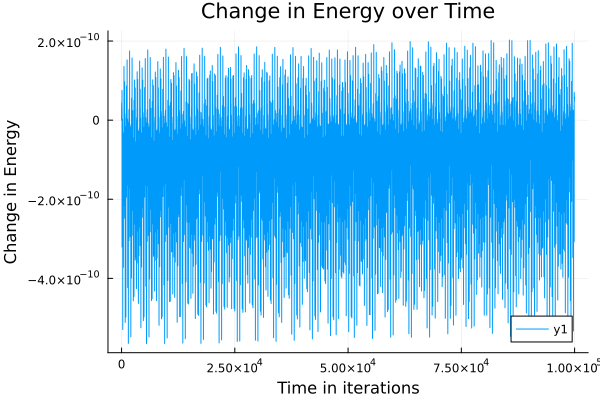

In [390]:
#Plot
Plots.plot(sol.t, [energy[i][1] - energy[1][1] for i in range(1, length(sol.u))], title="Change in Energy over Time",
    xaxis="Time in iterations", yaxis="Change in Energy")

In [391]:
# PlotlyJS.plot(PlotlyJS.scatter(x=getindex.(poi_points, 2), y=vr, mode="markers"))

In [392]:
theta_poi=[poi_points[i][3] for i in range(1,length(poi_points))];

In [393]:
minimum(theta_poi.-pi/2)

-5.497824417943775e-13

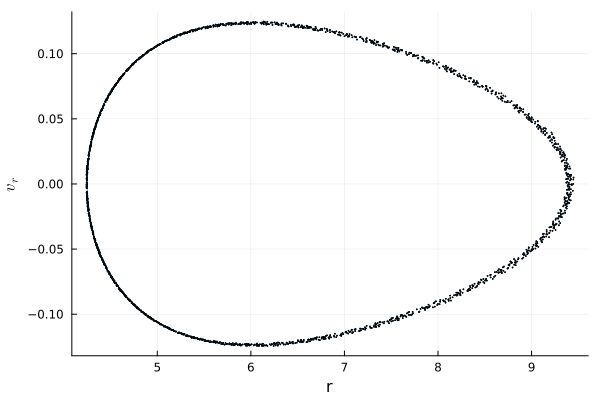

In [394]:
Plots.plot(getindex.(poi_points,2),vr, seriestype=:scatter, ms=0.5, legend=false)
xlabel!("r")
ylabel!(L"v_r")
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, theta=pi/2\\, Energy=0.9328e-4, Jz=2.8e-4, S=1e-4}"))
# Plots.savefig("Poincare_Plot_julia.png")
# Add a title with LaTeX
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, z=0\\, and\\, v_z>0\\,}"))

In [395]:
@vars dp0,dp2,ds0

(dp0, dp2, ds0)

In [396]:
EPS=1e-12

1.0e-12

In [397]:
rng = MersenneTwister(1234);

In [398]:
dy0=[0;randn(1);randn(1);randn(1);dp0/EPS;randn(1);dp2/EPS;randn(1);ds0/EPS;randn(1);randn(1);randn(1)].*EPS

12-element Vector{Basic}:
                     0
  3.87837294098633e-13
 -1.02682044237634e-12
  3.55773343625937e-13
               1.0*dp0
 -5.53553356267143e-14
               1.0*dp2
 -3.62982487526727e-13
               1.0*ds0
 -8.32896334709849e-13
  -1.1704722111457e-12
 -1.86320451625638e-12

In [399]:
y0

12-element Vector{Float64}:
 0.0
 6.0
 1.5707963267948966
 0.0
 1.3648588710410591e-6
 1.2409673645990855e-7
 1.688042347715563e-8
 8.585281516368291e-8
 5.724949096915607e-7
 8.273115763993904e-8
 1.6666666666666664e-8
 1.8174789707976532e-7

In [400]:
ry0 = dy0 .+ y0

12-element Vector{Basic}:
                              0
               6.00000000000039
               1.57079632679387
           3.55773343625937e-13
 1.36485887104106e-06 + 1.0*dp0
           1.24096681104573e-07
 1.68804234771556e-08 + 1.0*dp2
           8.58524521811954e-08
 5.72494909691561e-07 + 1.0*ds0
           8.27303247436043e-08
           1.66654961944555e-08
           1.81746033875249e-07

In [401]:
eqC1=expand(get_norm(ry0[5:8],gk)[1]+m^2)

1.75867772932435e-13 - 2.16695038479387e-06*dp0 + 2.86552419216505e-06*dp2 - 0.782912597326756*dp0^2 + 84.8771417388604*dp2^2

In [402]:
eqC2= expand(get_norm(ry0[9:end],gk)[1]-S^2)

1.56885128124832e-12 - 9.59554592510159e-07*ds0 - 0.782912597326756*ds0^2

In [403]:
@tensor begin
    eqC3[]:= gk[i,j]*ry0[5:8][j]*ry0[9:end][i]
end
eqC3=expand(eqC3[1])

7.10022830345299e-13 - 4.79777296255079e-07*dp0 + 1.41451968264524e-06*dp2 - 1.08347519239693e-06*ds0 - 0.782912597326756*ds0*dp0

In [404]:
feqC1=lambdify(eqC1,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [405]:
feqC2= lambdify(eqC2,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [406]:
feqC3= lambdify(eqC3,[dp0,dp2,ds0])

#36 (generic function with 1 method)

In [407]:
function const_sol_eq(p)
    [feqC1(p[1],p[2],p[3]),feqC2(p[1],p[2],p[3]),feqC3(p[1],p[2],p[3])]
end

const_sol_eq (generic function with 1 method)

In [408]:
const_sol=nlsolve(const_sol_eq,[m,m,m],ftol=1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0e-6, 1.0e-6, 1.0e-6]
 * Zero: [1.0e-6, 1.0e-6, 1.0e-6]
 * Inf-norm of residuals: 0.000000
 * Iterations: 0
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: true
 * Function Calls (f): 1
 * Jacobian Calls (df/dx): 1

In [409]:
dp0,dp2,ds0=const_sol.zero

3-element Vector{Float64}:
 1.0e-6
 1.0e-6
 1.0e-6

In [410]:
dy0[5]= dp0
dy0[7]= dp2
dy0[9]= ds0

1.0e-6

In [411]:
dy0

12-element Vector{Basic}:
                     0
  3.87837294098633e-13
 -1.02682044237634e-12
  3.55773343625937e-13
                 1e-06
 -5.53553356267143e-14
                 1e-06
 -3.62982487526727e-13
                 1e-06
 -8.32896334709849e-13
  -1.1704722111457e-12
 -1.86320451625638e-12

In [412]:
ry0=Float64.(dy0.+y0)

12-element Vector{Float64}:
 0.0
 6.000000000000388
 1.5707963267938698
 3.5577334362593747e-13
 2.364858871041059e-6
 1.2409668110457292e-7
 1.0168804234771557e-6
 8.585245218119539e-8
 1.5724949096915607e-6
 8.273032474360433e-8
 1.6665496194455518e-8
 1.8174603387524908e-7

In [413]:
function evolve_lyap2(y0, y1)
    ti = 0.0
    tf = last(t_span)
    tau = 1000
    timestep = LinRange(ti, tf, tau)
    li = zeros(length(timestep) - 1)
    EPS = 1e-6
    p=[a0,m,M,0]

    for i in 1:length(timestep) - 1
        tspan = (timestep[i], timestep[i+1])
        # f != ODEFunction(mpd!)
        prob = ODEProblem(mpd!, y0, tspan, p)
        soly0 = solve(prob, reltol=1e-11, abstol=1e-11, maxiters=1e6)

        prob = ODEProblem(mpd!, ry0, tspan, p)
        soly1 = solve(prob, reltol=1e-10, abstol=1e-8, maxiters=1e6)

        v1 = (soly1.u[end] .- soly0.u[end]) ./ norm(soly1.u[end] .- soly0.u[end])

        li[i] = log(norm(soly1.u[end] .- soly0.u[end]) / EPS) / tau

        y0 = soly0.u[end]
        y1 = y0 .+ EPS .* v1

    end

    return li
    

end

evolve_lyap2 (generic function with 1 method)

In [414]:
lis= evolve_lyap2(y0,ry0);

In [415]:
Statistics.mean(lis)

0.024607532589573947

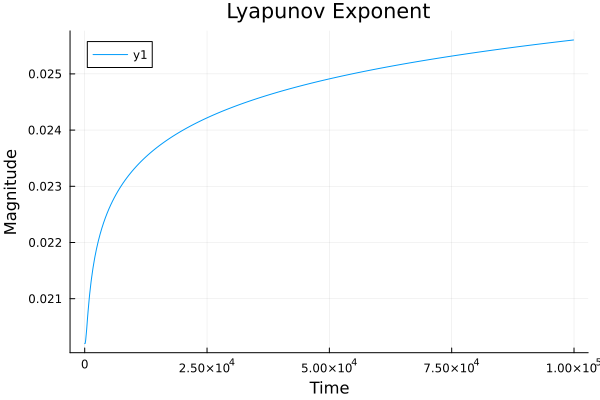

In [419]:
Plots.plot(LinRange(0, last(t_span), 1000)[1:end-1],lis,title="Lyapunov Exponent",
xaxis="Time",yaxis="Magnitude")